# Spotify Artist Recommendation Project - Modeling

We explored the time components of the data in each song in the [previous notebook](https://github.com/dvanheeswijk/Spotify/blob/master/Data%20Wrangling%20and%20EDA.ipynb). Now we will look to perform the task of creating an artist recommendation model. To do this, we begin by reading in the [data](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks) and libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from random import sample

from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('data/data.csv')

data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [3]:
genre = pd.read_csv('data/data_by_genres.csv')

genre.head()

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,21st century classical,0.754600,0.284100,3.525932e+05,0.159580,0.484374,0.168580,-22.153400,0.062060,91.351000,0.143380,6.600000,4,1
1,432hz,0.485515,0.312000,1.047430e+06,0.391678,0.477250,0.265940,-18.131267,0.071717,118.900933,0.236483,41.200000,11,1
2,8-bit,0.028900,0.673000,1.334540e+05,0.950000,0.630000,0.069000,-7.899000,0.292000,192.816000,0.997000,0.000000,5,1
3,[],0.535793,0.546937,2.495312e+05,0.485430,0.278442,0.220970,-11.624754,0.101511,116.068980,0.486361,12.350770,7,1
4,a cappella,0.694276,0.516172,2.018391e+05,0.330533,0.036080,0.222983,-12.656547,0.083627,105.506031,0.454077,39.086248,7,1


In [4]:
artists = pd.read_csv('data/data_w_genres.csv')

artists.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.407407,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,42.000000,5,1,7,[]


We will use the three data sets to help with some of the modeling. The majority of the data we will use in modeling and training/testing will be part of the **data** dataframe. The *genre* and *artists* dataframes will help with distinguishing how our model has done.

## Genre Clusters

We would like to create a model that clusters genres of songs together based on the commonality in audio features. In order to do this, we will need to clean the data just a bit to get what we want, before scaling and modeling.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

In [6]:
columns = genre.columns

columns

Index(['genres', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'popularity', 'key', 'mode'],
      dtype='object')

In [7]:
columns = columns[1:]
X = genre[columns]

In [8]:
# For our model to work best, we need to normalize the data
scaler = MinMaxScaler()

scaler.fit(X)

X_scaled = scaler.transform(X)

In [9]:
X_scaled = pd.DataFrame(X_scaled, columns=columns)

In [10]:
kmeans = KMeans()

n_clusters = range(1, 100)
error = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_scaled)
    error.append(kmeans.inertia_)

C:\Users\david\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


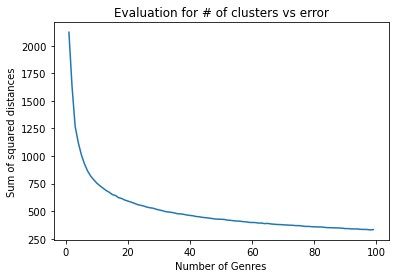

In [11]:
sns.lineplot(n_clusters,error)
plt.xlabel('Number of Genres')
plt.ylabel('Sum of squared distances')
plt.title('Evaluation for # of clusters vs error')

plt.show()

It appears that our best estimate for the number of clusters to use to create our "Super" Genres would be right around 20 or so genres. Thus we will create our "Super" genres using 20 clusters and apply them to the already existing genre data set.

In [12]:
best_kmeans = KMeans(n_clusters=20)

super_genres = best_kmeans.fit_predict(X_scaled)

genre['super_genre'] = super_genres

genre.head()

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,super_genre
0,21st century classical,0.754600,0.284100,3.525932e+05,0.159580,0.484374,0.168580,-22.153400,0.062060,91.351000,0.143380,6.600000,4,1,9
1,432hz,0.485515,0.312000,1.047430e+06,0.391678,0.477250,0.265940,-18.131267,0.071717,118.900933,0.236483,41.200000,11,1,0
2,8-bit,0.028900,0.673000,1.334540e+05,0.950000,0.630000,0.069000,-7.899000,0.292000,192.816000,0.997000,0.000000,5,1,7
3,[],0.535793,0.546937,2.495312e+05,0.485430,0.278442,0.220970,-11.624754,0.101511,116.068980,0.486361,12.350770,7,1,18
4,a cappella,0.694276,0.516172,2.018391e+05,0.330533,0.036080,0.222983,-12.656547,0.083627,105.506031,0.454077,39.086248,7,1,6


So, let's take a quick look at our 20 super genres to confirm that they make sense.

Text(0.5, 1.0, 'Number of genres per super genre')

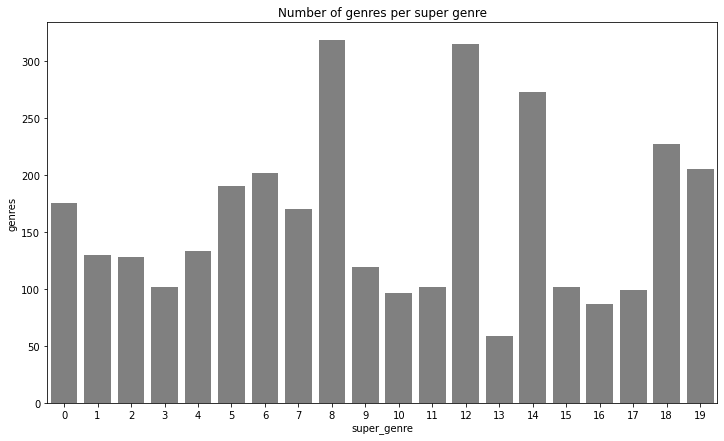

In [13]:
genre_count = genre.groupby('super_genre')['genres'].count()

plt.figure(figsize=(12,7))
sns.barplot(x = genre_count.index, y=genre_count, color='gray')
plt.title('Number of genres per super genre')

We see that the number of genres per super genre ranges dramatically from one with about 10 total genres to some with nearly 250. We will investigate a couple super genres to see if the combinations make sense.

In [14]:
print(genre[genre['super_genre']==17]['genres'])

24                          adoracao
50                  albanian hip hop
111                 arab alternative
143                    atlanta indie
163           australian black metal
                    ...             
2941    technical brutal death metal
2944             technical grindcore
3037                     turkish edm
3077                   uk tech house
3121                vgm instrumental
Name: genres, Length: 99, dtype: object


In [15]:
# Sample from super genre 4
print(sample(list(genre[genre['super_genre']==4]['genres']),15))

['kids dance party', 'guadalajara indie', 'turkish experimental', 'channel islands indie', 'arkansas hip hop', 'shimmer psych', 'folklore boliviano', 'trap boricua', 'j-reggae', 'baltimore hip hop', 'peruvian hip hop', 'denpa-kei', 'jazz colombiano', 'west virginia indie', 'indian singer-songwriter']


In [16]:
# Sample from super genre 0
print(sample(list(genre[genre['super_genre']==0]['genres']),15))

['impressionism', 'contemporary jazz', 'baroque cello', 'theme', 'american romanticism', 'greek contemporary classical', 'swiss classical piano', 'tone', 'christian relaxative', 'scottish jazz', 'harpsichord', 'armenian folk', 'lo-fi house', 'classical piano duo', 'deep soundtrack']


In [17]:
# Sample from super genre 12
print(sample(list(genre[genre['super_genre']==12]['genres']),15))

['kaneka', 'nashville hip hop', 'salsa choke', 'modern reggae', 'europop', 'argentine hip hop', 'cumbia sonidera', 'pop rock brasileiro', 'tropical', 'pop r&b', 'kingston on indie', 'argentine rock', 'pop peruano', 'dub', 'new wave pop']


In [18]:
# Sample from super genre 18
print(sample(list(genre[genre['super_genre']==18]['genres']),15))

['mambo', 'swing italiano', 'entehno', 'jazz vibraphone', 'bebop', 'jazz piano', 'jazz trumpet', 'free jazz', 'islamic recitation', 'vintage jazz', 'sitar', 'french soundtrack', 'classical mandolin', 'orquesta tipica', 'bouzouki']


In [19]:
# Sample from super genre 3
print(sample(list(genre[genre['super_genre']==3]['genres']),15))

['progressive deathcore', 'scottish electronic', 'czech hip hop', 'chicago hardcore', 'rawstyle', 'pop house', 'sky room', 'classic hardstyle', 'fast melodic punk', 'el paso indie', 'breakbeat', 'deep big room', 'maine indie', 'chaotic hardcore', 'deep eurodance']


We find that the super genres tend to have some similarities that pop out. When we look at super genre 17, we find that it is full of genres that are more spoken word like comedy, poetry, and reading. However, we also see that there are a few genres that maybe don't have as much in common with comedy, such as classic hungarian pop.

Looking at a few other super genres gives us the feeling that, within each super genre, there are smaller clusters of similar genres that are put together in the super genre. For example, in super genre 18, there are indie folk, brooklyn indie, and piano rock together in the same super genre as trap, scam rap, and manchester hip hop. Clearly the first three have similarities to each other, but not as much with the second three. To remedy this, we would need to either create more super genres, or recognize that this phenomena will happen with fewer super genres.

## Artist Recommendation

We will now switch to our other task, which is to create an artist recommendation model. To do this, we will use the data and artists dataframes to create our training data set.

In [20]:
artists = pd.read_csv('data/data_w_genres.csv')

artists.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10,['show tunes']
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,26,[]
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,7,[]
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.407407,0,1,27,[]
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,42.000000,5,1,7,[]


In [21]:
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


As we had before, we are going to need to cluster the artists genres based on the data available. Thus, we will create another cluster to create "genres" for each artists, given the audio features for each given artist.

In [22]:
scaler = MinMaxScaler()
artists[columns] = scaler.fit_transform(artists[columns])

In [23]:
artists.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
count,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000,32539.000000
mean,0.457512,0.560017,0.051306,0.525908,0.233281,0.212003,0.773144,0.094796,0.534195,0.500313,0.260356,0.496344,0.734903,12.561818
std,0.385219,0.178769,0.033737,0.267402,0.334487,0.153936,0.087879,0.114580,0.111300,0.247898,0.244905,0.315787,0.441392,52.407821
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.055377,0.442237,0.036774,0.299000,0.000012,0.110548,0.729204,0.040886,0.459365,0.306712,0.000000,0.181818,0.000000,2.000000
50%,0.393407,0.570415,0.045528,0.537375,0.009550,0.164300,0.790838,0.054399,0.540315,0.507523,0.241135,0.545455,1.000000,2.000000
75%,0.879518,0.693516,0.058342,0.747039,0.451149,0.263185,0.837273,0.093512,0.593869,0.693581,0.458957,0.727273,1.000000,7.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3179.000000


In [24]:
knn = KMeans(n_clusters=20)

artists['genres'] = knn.fit_predict(artists[columns])

artists.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres
0,"""Cats"" 1981 Original London Cast",0.600904,0.476292,0.055246,0.376203,0.010261,0.287069,0.719076,0.215396,0.519161,0.359398,0.406383,0.454545,1.0,10,14
1,"""Cats"" 1983 Broadway Cast",0.866002,0.447549,0.059556,0.406808,0.081158,0.319691,0.778165,0.181474,0.468738,0.269674,0.335516,0.454545,1.0,26,8
2,"""Fiddler On The Roof” Motion Picture Chorus",0.860011,0.352873,0.068437,0.286571,0.024593,0.330411,0.706508,0.122054,0.351976,0.355925,0.367781,0.000000,1.0,7,8
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.888480,0.430673,0.054354,0.245770,0.073587,0.279393,0.700059,0.126880,0.403341,0.373149,0.366036,0.000000,1.0,27,8
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.512765,0.473296,0.055964,0.488286,0.009400,0.197769,0.785319,0.101486,0.558769,0.483737,0.446809,0.454545,1.0,7,14


Now that we have a cluster for artists, we can look into creating a recommendation system for a given user. The way we will do this is by creating a set of "users" that have first rated song on a scale of 1-10. We will then use the user rating data to create a recommendation of 5 artists based on preference.

In [25]:
artists['user_id'] = np.random.randint(1000,1500,len(artists))
artists['rating'] = np.random.randint(1,11,len(artists))

artists.head()

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,genres,user_id,rating
0,"""Cats"" 1981 Original London Cast",0.600904,0.476292,0.055246,0.376203,0.010261,0.287069,0.719076,0.215396,0.519161,0.359398,0.406383,0.454545,1.0,10,14,1384,5
1,"""Cats"" 1983 Broadway Cast",0.866002,0.447549,0.059556,0.406808,0.081158,0.319691,0.778165,0.181474,0.468738,0.269674,0.335516,0.454545,1.0,26,8,1193,9
2,"""Fiddler On The Roof” Motion Picture Chorus",0.860011,0.352873,0.068437,0.286571,0.024593,0.330411,0.706508,0.122054,0.351976,0.355925,0.367781,0.000000,1.0,7,8,1046,3
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.888480,0.430673,0.054354,0.245770,0.073587,0.279393,0.700059,0.126880,0.403341,0.373149,0.366036,0.000000,1.0,27,8,1105,3
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.512765,0.473296,0.055964,0.488286,0.009400,0.197769,0.785319,0.101486,0.558769,0.483737,0.446809,0.454545,1.0,7,14,1433,1


In [90]:
def user_recommend(user_id):
    user_genres =  list(dict.fromkeys(artists[artists['user_id']==user_id].sort_values('rating', ascending=False)['genres'][:5]))
    new_artists = artists[artists['genres'].isin(user_genres)].sort_values('popularity',ascending=False)['artists']
    return sample(list(new_artists),10)

In [27]:
recommend(1014)

['Leaving Laurel',
 'Pandrezz',
 'Nina Simone',
 'Evan Rachel Wood',
 'Carin Leon',
 'Stacy Barthe',
 'Level 42',
 'Gregg Allman',
 'Wilson "Saoko" Manyoma',
 'Rocksolid']

In [79]:
artists[artists['user_id']==1014].sort_values('rating',ascending=False)[['artists','genres', 'rating']].head(10)

,artists,genres,rating
32526,高慧君,14,10
11623,Harry Axt,15,10
6086,D-Shott,13,9
17395,Lovesliescrushing,7,9
8703,Emmanuel,10,9
28868,The Prades Festival Orchestra,0,9
1743,Anthrax,3,9
26794,Stockholm Radio Chorus,0,9
7002,Debbie Deb,6,8
6136,D@n Deejay,9,8


## Artist Recommendation - Part 2

What if, instead of basing our artist recommendations on how a given user "rates" songs, we instead wanted to find artists that were all similar to a given set of artists. I like to think of this as *merging the artists*, or simply taking the audio feature from several artists, averaging them out, then producing a list of artists that are close in overall features to that average. We first define a recommendation class **ArtistsMerge**.

In [84]:
class ArtistsMerge():
    def __init__(self):
        self.data = None    # Data set with artists and audio features
        self.items = None   # List of features to use for merging artists
        self.artist = None  # List of artists to merge together
        self.combo = None   # Place holder for our average of all audio features
        self.n = None       # Number of recommendations
        
# Instantiates the class with a data set, list of artists, list of features, and optional number of recommendations        
    def create(self, data, artist, items, n=10):
        self.data = data
        self.items = items
        self.artist = artist
        self.combo = self.get_combo(artist, items)
        self.n = n
        
# Used to average all audio features among artists        
    def mean(self, a):
        return sum(a) / len(a)
    
# Gives us our "score", with 0 being the best    
    def abs_error(self,a, b):
        j = 0
        i = 0
        for j in range(0,len(a)):
            i += abs(a[j] - b[j])
        return i

# Flattens an artists features into a list    
    def get_artist_features(self, a, items):
        return list(a[items].values.flatten())

# Produces list of average features using *mean* and *get_artist_features*
    def get_combo(self, artist, items):
        a_list = []
        for a in artist:
            a_data = self.data[self.data['artists']==a].reset_index()
            a_items = self.get_artist_features(a_data,items)
            a_list.append([i for i in a_items])
        return list(map(self.mean, zip(*a_list)))

# Produces our recommendation list
    def recommend(self):
        other_artist_data = self.data.drop(self.data[self.data['artists'].isin(self.artist)].index)
        score = {}
        for index, row in other_artist_data.iterrows():
            score[row['artists']] = (self.abs_error(self.get_artist_features(row, self.items), self.combo))
        return list({k+": "+str(v): v for k, v in sorted(score.items(), key=lambda item: item[1])})[:self.n]        
        

We will now test our class using 3 musical acts that are relatively similar:
* St. Lucia
* Disclosure
* Daft Punk

Additionally, we will also restate our number of recommendations as 5 instead of the default 10.

In [85]:
test_list = ['St. Lucia', 'Disclosure', 'Daft Punk']
features = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']

rec = ArtistsMerge()

In [88]:
rec.create(artists, test_list, features, 5)

In [89]:
rec.recommend()

['Spice Girls: 0.23724548449127913',
 'Beck: 0.2454543933384004',
 'Diplo: 0.25501301502596496',
 'Nathan Haines: 0.26538614234024027',
 'Jamiroquai: 0.26580045198542857']

Seems to work!! Now, lets combine the two recommendations given, one for user ratings, and the other for audio similarities.

In [92]:
user_1111 = user_recommend(1111)
rec_1111 = ArtistsMerge()
rec_1111.create(artists, user_1111, features, 8)

In [93]:
rec_1111.recommend()

['B.B. King: 0.21729196191001213',
 'Harry Guardino: 0.23550764642953936',
 'Esmeray: 0.2407467872730038',
 'Miguel Gallardo: 0.2471321592422029',
 'The New Merseysiders: 0.2613388530726246',
 'James Brown & The Famous Flames: 0.2720730067204967',
 'June Carter Cash: 0.28983538422919',
 'Billy Gilman: 0.29355188185019554']

Great! Seems to give what we were looking for, which was a way to recommend a number of artists based on user ratings. Our next task would be to create a recommendation based on play count rather than ratings, to give a different way of recommending artists.

## Song Recommendation

What we would really like to do is create a recommendation for songs based on a listener's previously played songs. For this purpose, we are going to create a fake list of users and how many times they listened to certain songs. With this, we will then take each user's top 5 songs, and recommend the next song as a result.

In [29]:
data['artists'] = data['artists'].str.replace('"', '').str.replace("'","").str.replace('[','').str.replace(']','')

In [30]:
scaler = MinMaxScaler()
data[columns] = scaler.fit_transform(data[columns])

In [31]:
data.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000,174389.000000
mean,0.501233,0.543277,0.042726,0.482721,0.068135,0.197252,0.473210,0.211123,0.755605,0.702384,0.256934,0.108887,0.480506,0.524533,1977.061764
std,0.381462,0.178163,0.027824,0.272685,0.251978,0.334574,0.319845,0.180493,0.089133,0.457211,0.218727,0.187704,0.124244,0.264477,26.907950
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1920.000000
25%,0.088052,0.419028,0.030224,0.249000,0.000000,0.000000,0.181818,0.099200,0.706162,0.000000,0.010000,0.036251,0.385743,0.311000,1955.000000
50%,0.519076,0.554656,0.037659,0.465000,0.000000,0.000524,0.454545,0.138000,0.769932,1.000000,0.250000,0.046859,0.475617,0.536000,1977.000000
75%,0.898594,0.677126,0.048897,0.711000,0.000000,0.252000,0.727273,0.270000,0.822191,1.000000,0.420000,0.078579,0.554444,0.743000,1999.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2021.000000


In [32]:
data.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.994980,Mamie Smith,0.605263,0.030637,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,0.454545,0.3790,0.741868,0.0,Keep A Song In Your Soul,0.12,1920,0.096395,0.615900,0.6340,1920
1,0.645582,Screamin Jay Hawkins,0.862348,0.027237,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,0.454545,0.0809,0.825918,0.0,I Put A Spell On You,0.07,1920-01-05,0.054995,0.356823,0.9500,1920
2,0.996988,Mamie Smith,0.654858,0.029792,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0.000000,0.5190,0.750168,1.0,Golfing Papa,0.04,1920,0.179197,0.400810,0.6890,1920
3,0.000174,Oscar Velazquez,0.738866,0.078215,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,0.181818,0.1280,0.825135,1.0,True House Music - Xavier Santos & Carlos Gomi...,0.17,1920-01-01,0.043769,0.525640,0.0422,1920
4,0.296185,Mixe,0.712551,0.030054,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,0.909091,0.4020,0.845102,0.0,Xuniverxe,0.02,1920-10-01,0.079094,0.501324,0.2990,1920


In [33]:
# Creating a "decade" feature which may help with recommendations
data['decade'] = pd.qcut(data['year'],10)

In [34]:
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172230 entries, 0 to 174387
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   acousticness      172230 non-null  float64 
 1   artists           172230 non-null  object  
 2   danceability      172230 non-null  float64 
 3   duration_ms       172230 non-null  float64 
 4   energy            172230 non-null  float64 
 5   explicit          172230 non-null  int64   
 6   id                172230 non-null  object  
 7   instrumentalness  172230 non-null  float64 
 8   key               172230 non-null  float64 
 9   liveness          172230 non-null  float64 
 10  loudness          172230 non-null  float64 
 11  mode              172230 non-null  float64 
 12  name              172230 non-null  object  
 13  popularity        172230 non-null  float64 
 14  release_date      172230 non-null  object  
 15  speechiness       172230 non-null  float64 
 16  te

In [35]:
data['id'].is_unique

True

In [36]:
data.reset_index(inplace=True)
data.head()

,index,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,...,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year,decade
0,0,0.994980,Mamie Smith,0.605263,0.030637,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,0.454545,...,0.741868,0.0,Keep A Song In Your Soul,0.12,1920,0.096395,0.615900,0.6340,1920,"(1919.999, 1940.0]"
1,1,0.645582,Screamin Jay Hawkins,0.862348,0.027237,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,0.454545,...,0.825918,0.0,I Put A Spell On You,0.07,1920-01-05,0.054995,0.356823,0.9500,1920,"(1919.999, 1940.0]"
2,2,0.996988,Mamie Smith,0.654858,0.029792,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0.000000,...,0.750168,1.0,Golfing Papa,0.04,1920,0.179197,0.400810,0.6890,1920,"(1919.999, 1940.0]"
3,3,0.000174,Oscar Velazquez,0.738866,0.078215,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,0.181818,...,0.825135,1.0,True House Music - Xavier Santos & Carlos Gomi...,0.17,1920-01-01,0.043769,0.525640,0.0422,1920,"(1919.999, 1940.0]"
4,4,0.296185,Mixe,0.712551,0.030054,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,0.909091,...,0.845102,0.0,Xuniverxe,0.02,1920-10-01,0.079094,0.501324,0.2990,1920,"(1919.999, 1940.0]"


In [37]:
data.drop(columns='index',inplace=True)

We dropped a few duplicated rows and have discerned that the 'id' column holds a unique index for each song. We will use this as our independent variable, then convert the id to its corresponding artists/song recommendation.

Now, we are ready to make a dummy user with a play count for each song. We will make the listening set sparse by filling the majority of the songs with 0, then focus on 25000 songs to place randomized listening habits. For the sake of this exercise, songs will be played no more than 100 times by the user.

In [38]:
data['user_play_count'] = 0

listeners_list = [np.random.randint(0,len(data)) for i in range(0,25000)]

In [39]:
for i in listeners_list:
    data.loc[i,'user_play_count'] = np.random.randint(0,101)

Text(0.5, 1.0, 'Random User listens count')

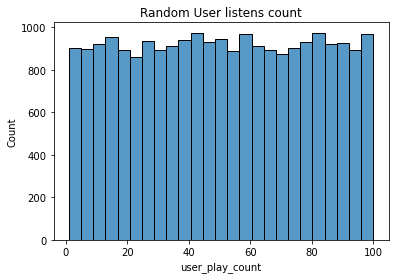

In [40]:
sns.histplot(data[data['user_play_count']>0]['user_play_count'],bins=25)
plt.title('Random User listens count')

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172230 entries, 0 to 172229
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   acousticness      172230 non-null  float64 
 1   artists           172230 non-null  object  
 2   danceability      172230 non-null  float64 
 3   duration_ms       172230 non-null  float64 
 4   energy            172230 non-null  float64 
 5   explicit          172230 non-null  int64   
 6   id                172230 non-null  object  
 7   instrumentalness  172230 non-null  float64 
 8   key               172230 non-null  float64 
 9   liveness          172230 non-null  float64 
 10  loudness          172230 non-null  float64 
 11  mode              172230 non-null  float64 
 12  name              172230 non-null  object  
 13  popularity        172230 non-null  float64 
 14  release_date      172230 non-null  object  
 15  speechiness       172230 non-null  float64 
 16  te